# Mental Health Data Analysis

Exploring the counseling dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
sns.set()

# Read the CSV file
df = pd.read_csv('nlp_mental_health.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (3512, 2)

Columns: ['Context', 'Response']

First few rows:


,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [2]:
# Display detailed information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [3]:
context_counts = df['Context'].value_counts()
print("\nTotal unique contexts:", len(context_counts))
response_counts = df['Response'].value_counts()
print("\nTotal unique responses:", len(response_counts))
# Remove rows with null values in either Context or Response
df = df.dropna(subset=['Context', 'Response'])


Total unique contexts: 995

Total unique responses: 2479



Context Length Statistics:
count    3508.000000
mean       55.195268
std        48.288581
min         5.000000
25%        28.000000
50%        46.000000
75%        68.000000
max       526.000000
Name: Context_Length, dtype: float64

Response Length Statistics:
count    3508.000000
mean      177.203820
std       120.665564
min         1.000000
25%        94.000000
50%       145.000000
75%       221.000000
max       939.000000
Name: Response_Length, dtype: float64


<Figure size 1500x600 with 0 Axes>

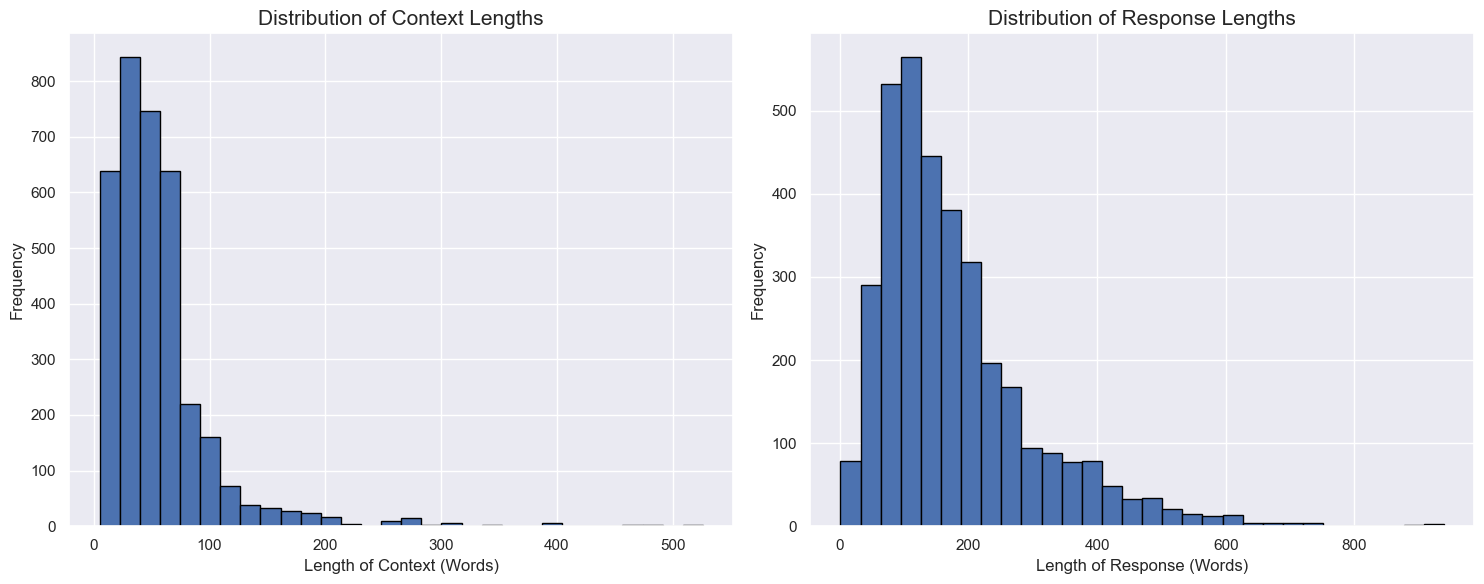

In [4]:
# Calculate word lengths for both columns
df['Context_Length'] = df['Context'].str.split().str.len()
df['Response_Length'] = df['Response'].str.split().str.len()

# Create visualization
plt.figure(figsize=(15, 6))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot Context lengths
axs[0].hist(df['Context_Length'], bins=30, edgecolor='black')
axs[0].set_xlabel("Length of Context (Words)", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)
axs[0].set_title("Distribution of Context Lengths", fontsize=15)

# Plot Response lengths
axs[1].hist(df['Response_Length'], bins=30, edgecolor='black')
axs[1].set_xlabel("Length of Response (Words)", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)
axs[1].set_title("Distribution of Response Lengths", fontsize=15)

plt.tight_layout()

# Print summary statistics
print("\nContext Length Statistics:")
print(df['Context_Length'].describe())
print("\nResponse Length Statistics:")
print(df['Response_Length'].describe())

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Function to detect direct advice in responses
def contains_direct_advice(text):
    # Keywords and phrases that might indicate direct advice
    advice_patterns = [
        r'should\b', r'need to\b', r'recommend\b', r'suggest\b', r'try\b',
        r'consider\b', r'must\b', r'have to\b', r'could\b', r'would\b',
        r'advice\b', r'advise\b', r'help\b', r'important to\b', r'best to\b',
        r'encourage\b', r'focus on\b', r'start by\b', r'first step\b'
    ]
    
    # Check if any of the patterns exist in the text
    return any(re.search(pattern, text.lower()) for pattern in advice_patterns)

# Create target variable
df['contains_advice'] = df['Response'].apply(contains_direct_advice)

# Prepare features and target
X = df['Context']
y = df['contains_advice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=1000,  # Reduced features
        min_df=3,          # Minimum document frequency
        max_df=0.95,       # Maximum document frequency
        ngram_range=(1, 2)  # Include bigrams
    )),
    ('scaler', StandardScaler(with_mean=False)),  # Cannot center sparse matrices
    ('classifier', LogisticRegression(
        C=0.1,               # Regularization strength
        class_weight='balanced',
        random_state=42,
        max_iter=2000,
        solver='saga'        # Different solver
    ))
])

# Fit pipeline
pipeline.fit(X_train, y_train)
print("Class distribution:")
print(df['contains_advice'].value_counts())

Class distribution:
contains_advice
True     2940
False     568
Name: count, dtype: int64


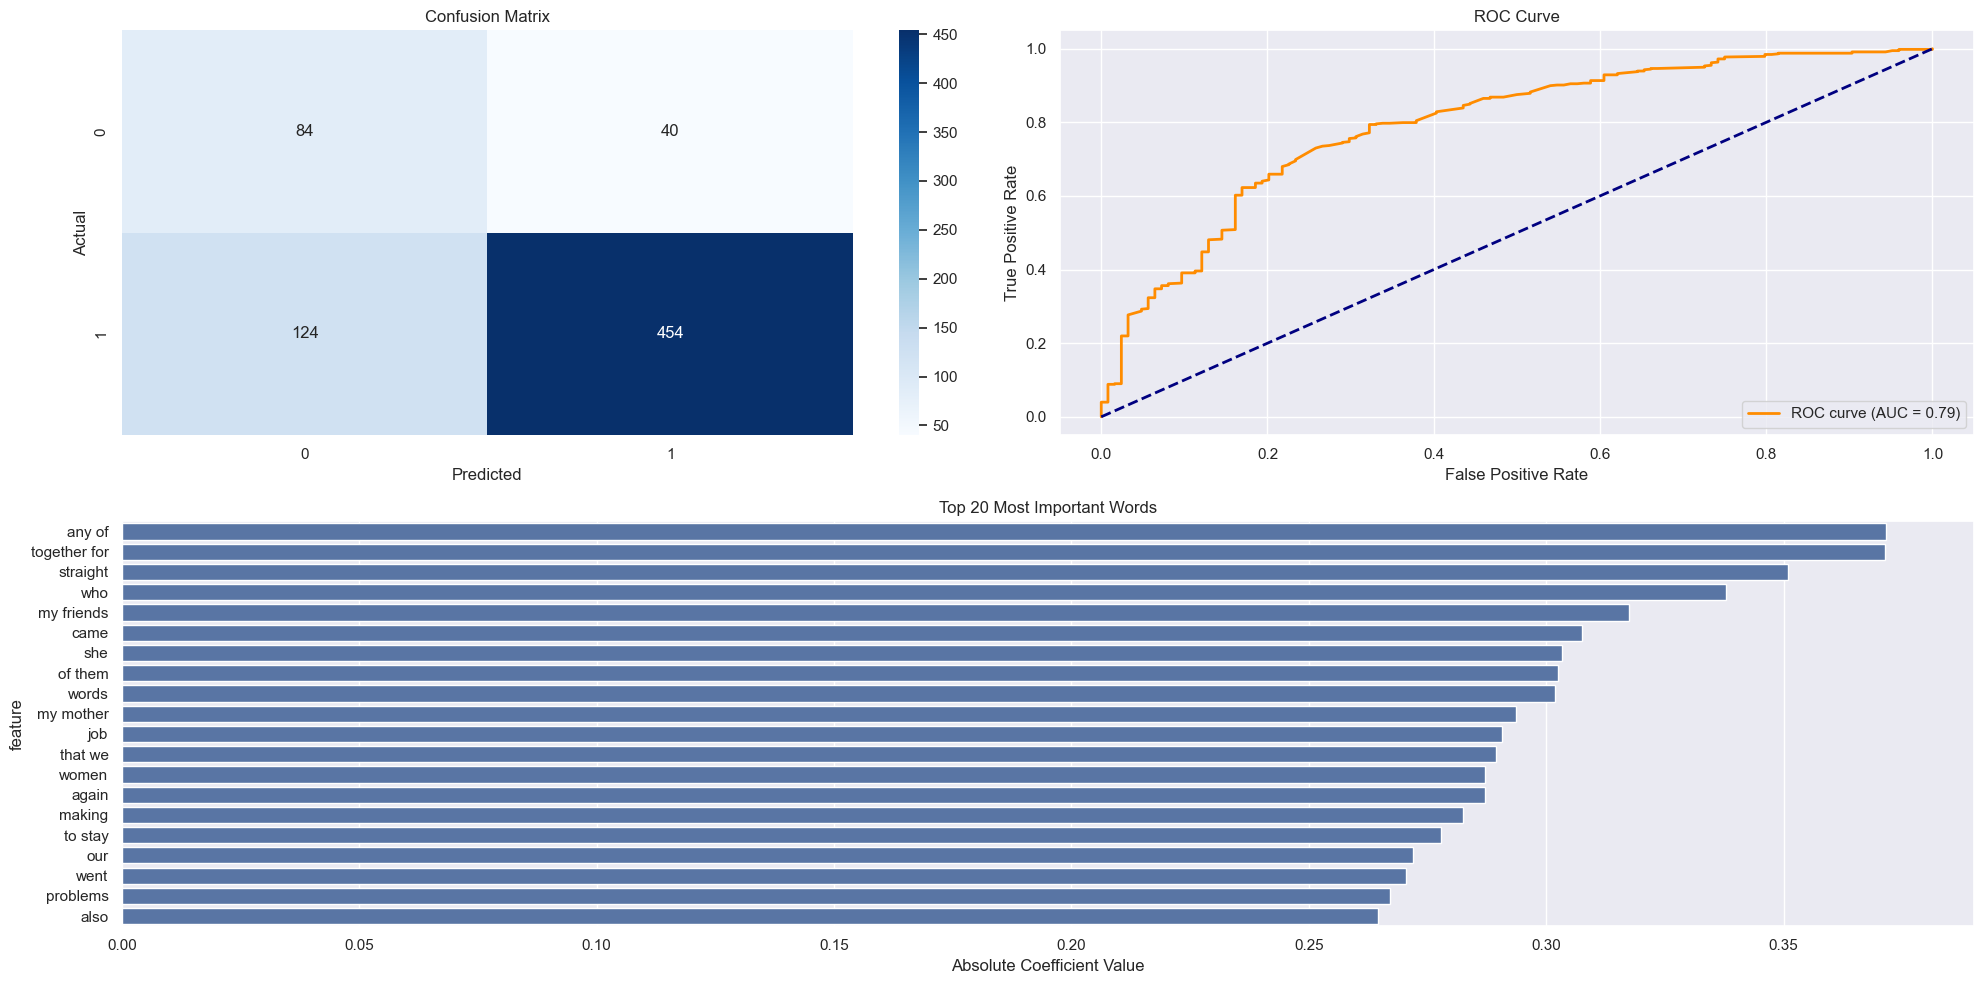

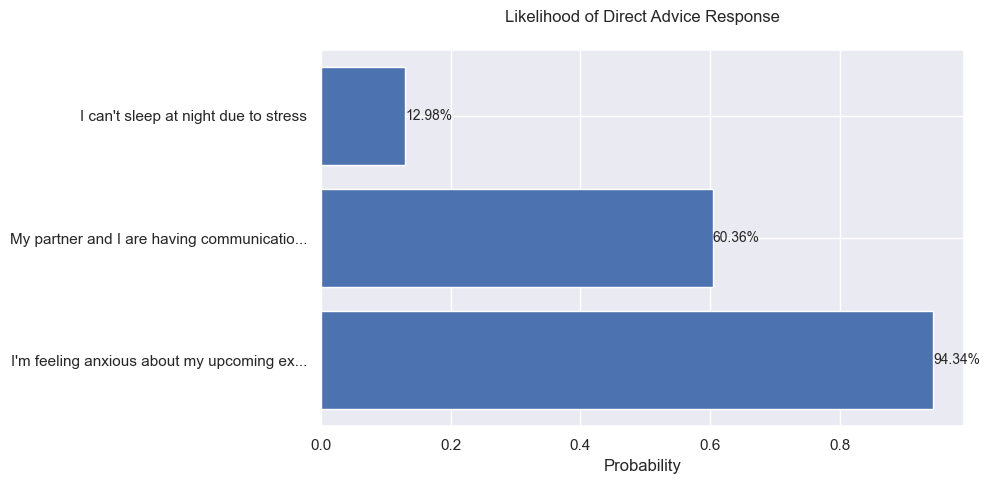

In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Get predictions and probabilities
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Create figure with subplots
plt.figure(figsize=(20, 10))

# 1. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 3. Top Features Visualization
plt.subplot(2, 1, 2)
# Get feature names and coefficients from pipeline
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(coefficients)
}).sort_values('importance', ascending=False)

# Plot top 20 features
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Words')
plt.xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()

# Example predictions visualization
example_texts = [
    "I'm feeling anxious about my upcoming exam",
    "My partner and I are having communication issues",
    "I can't sleep at night due to stress"
]

# Get predictions using the correct function
probs = []
texts_short = []

def predict_advice_likelihood(text):
    return pipeline.predict_proba([text])[0][1]

for text in example_texts:
    prob = predict_advice_likelihood(text)
    probs.append(prob)
    # Shorten text for better visualization
    texts_short.append(text[:40] + '...' if len(text) > 40 else text)

# Create visualization
plt.figure(figsize=(10, 5))
bars = plt.barh(texts_short, probs)
plt.title('Likelihood of Direct Advice Response', pad=20)
plt.xlabel('Probability')

# Add probability values on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{probs[i]:.2%}',
             ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()
